In [7]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt

from Generation import *
from Calculations import *
from SSWM import *

In [37]:
#Set initial parameters
M, N, K = 10, 20, 3
coefLambda, coefC, coefBeta = 1, 1, 0.85
h = 1.5 #0 < h < K/2 #Чем меньше, тем адекватнее
p_mut = 1/N
T_stop = 500
N_pop = 1 # Only one boolean vector

In [10]:
#Simple flip mutation
def mutate(s, N, N_pop, p_mut):
    for i in range(N_pop):
        for j in range(N):
            r = np.random.sample()
            if (r <= p_mut):
                s[j, i] = 1 - s[j, i]
    return s   

In [13]:
#Generating matrices W, B, C
def generateWBC(N, M, K):
    #Generating W MxN matrix, that holds weights w_i_j for f_i(s) = sigmoid(sum(w_i_j*s_j) - h_i)
    #Poisson dist for non-zero weights. It consists of Ki - values representing number of non-zero weights
    poisson_distr = np.random.poisson(K, size=(N,))
    
    print("--------------DEBUG---------------")
    print("Average non-zero:", np.absolute(poisson_distr.mean()))
    print("Weights M vector for M traits: ", poisson_distr)
    
    W = np.zeros((N,M))
    for i in range(N):
        #Generating -1 and 1 weights
        weights = np.random.choice([1,-1], size=poisson_distr[i], p=[0.5, 0.5])
        #Generating M - Ki zero weights
        weights = np.concatenate( (weights, np.zeros( (M - poisson_distr[i], ) ) ) )
        
        weights = np.random.permutation(weights)
        W[i] = weights
    W = W.astype(int)

    #Generating B
    B = np.random.uniform(low=1.0, high=10.0, size=(M,M))
    B = np.tril(B) + np.tril(B, -1).T
    
    #Generating C
    C = np.random.uniform(low=1.0, high=10.0, size=(M,))
    
    return (W, B, C)

In [14]:
#Generating boolean vector
def generateGenPool(N, N_pop):
    s = np.random.choice([0,1], (N, N_pop))
    return s
    

In [9]:
def SSWM(M, N, K, coefLambda, coefC, coefBeta, h, p_mut, T_stop, N_pop, W, B, C):
    C = C.reshape(-1,)
    fitnessValues = []
    
    #Calculating max W and Fitness
    W_max = np.dot(((linalg.inv(B))@C), C)
    W_max = -W_max/2
    F_max = coefC*np.exp(W_max*coefLambda)
    
    #Generating genetic pool
    s = generateGenPool(N, N_pop)
    F = calculate_Fitness(B, C, W, s, h, coefC, coefLambda, M, N)
    
    print("------DEBUG-----\nInitial F -", F)
    T = 0
    while (T < T_stop and F < coefBeta*F_max):
        F = calculate_Fitness(B, C, W, s, h, coefC, coefLambda, M, N)
        fitnessValues.append(F)
        
        s_mut = mutate(s, N, N_pop, p_mut)
        F_mut = calculate_Fitness(B, C, W, s_mut, h, coefC, coefLambda, M, N)
        if (F_mut > F):
            s = s_mut
        T += 1
    
    plt.plot(range(T), fitnessValues)
    plt.show()
    return (F_max, W_max, fitnessValues)

In [29]:
#Calculate fitness F = coefC * exp(coefLambda * W_fit)
def calculate_Fitness(B, C, W, s, h, coefC, coefLambda, M, N):
    F = calculate_F(W, s, h, M, N)
    
    #W_fit = (B*F, F)/2  + (C, F) or W_fit = sum(C[i]F[i]) + sum(sum(B[i][j]*F[i]*F[j]))
    W_fit = np.dot((B@F), F)/2 + np.dot(C, F)
    print("-------------Fitness-----------", (B@F), np.dot((B@F), F)/2, np.dot(C, F), sep = "\n")

    return coefC*np.exp(coefLambda*W_fit)

In [28]:
#Calculate vector F: f_i = sigmoid(sum(W[i][j]*s[i]) - h)
def calculate_F(W, s, h, M, N):
    F = np.zeros(M, )
    print("--------Trait F------------")
    for j in range(M):
        f_j = 0
        for i in range(N):
            f_j += W[i][j]*s[i]
            
        print(f_j, f_j-h, end=" ")
        f_j = f_j - h
        #Sigmoid
        F[j] = 1/(1 + np.exp(-0.5*f_j))
        print(F[j])
    return F

In [38]:
W,B,C = generateWBC(N,M,K)

--------------DEBUG---------------
Average non-zero: 3.2
Weights M vector for M traits:  [4 2 1 5 3 5 4 5 5 2 3 3 2 1 3 0 6 3 3 4]


In [39]:
print(B)

[[5.2892784  9.76876655 8.3291675  6.96081046 7.09306651 8.47888001
  4.26844478 5.50953449 6.99524991 1.22532383]
 [9.76876655 2.12839142 7.87274602 4.58621832 2.92088426 1.03065207
  7.44402593 6.24135637 5.13122729 4.52329278]
 [8.3291675  7.87274602 6.38999206 6.66287937 5.4499627  5.88278869
  3.89836897 6.49464716 8.39194394 6.50976188]
 [6.96081046 4.58621832 6.66287937 2.19969465 8.00285158 7.88391524
  4.18293746 5.25612764 1.91987016 4.13078777]
 [7.09306651 2.92088426 5.4499627  8.00285158 2.92306841 9.8203391
  4.57210894 9.59008298 8.42686509 6.75575353]
 [8.47888001 1.03065207 5.88278869 7.88391524 9.8203391  4.19509592
  1.50841045 8.68525914 5.10599965 5.06155415]
 [4.26844478 7.44402593 3.89836897 4.18293746 4.57210894 1.50841045
  6.72157197 1.89242851 5.25810864 5.60674967]
 [5.50953449 6.24135637 6.49464716 5.25612764 9.59008298 8.68525914
  1.89242851 9.502189   1.59414789 8.16816529]
 [6.99524991 5.13122729 8.39194394 1.91987016 8.42686509 5.10599965
  5.25810864 

--------Trait F------------
[-1] [-2.5] 0.22270013882530884
[-1] [-2.5] 0.22270013882530884
[-1] [-2.5] 0.22270013882530884
[0] [-1.5] 0.320821300824607
[3] [1.5] 0.679178699175393
[1] [-0.5] 0.43782349911420193
[1] [-0.5] 0.43782349911420193
[1] [-0.5] 0.43782349911420193
[-1] [-2.5] 0.22270013882530884
[0] [-1.5] 0.320821300824607
-------------Fitness-----------
[22.20320653 16.89483863 21.95359987 19.53363223 22.54075605 21.68766593
 15.32536623 24.02992187 18.84999045 18.64071005]
36.0382442818614
19.99311267450708
------DEBUG-----
Initial F - 2.158286725910056e+24


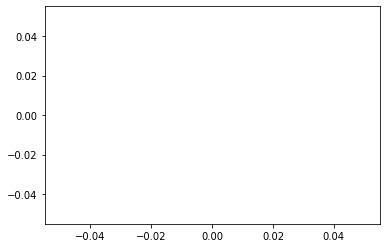

(2.7983120853381878, 1.029016408743176, [])

In [40]:
#При больших K, B, C случается переполнение в calculate_Fitness
F_max, W_max, vals = SSWM(M, N, K, coefLambda, coefC, coefBeta, h, p_mut, T_stop, N_pop, W, B, C)
F_max, W_max, vals